# Cluster analysis (Hierarchical + Stability)
### This notebook computes a dendrogram, compares Agglomerative clustering with existing KMeans labels, and performs bootstrap stability checks (Adjusted Rand Index). 
### Saved outputs: results/plots/dendrogram.png, results/cluster_stability.csv, appended summary to results/segmentation_report.txt

In [10]:
# Section: Kernel & environment check
import sys, platform
print('Python executable:', sys.executable)
print('Python version:', platform.python_version())


Python executable: /bin/python
Python version: 3.13.9


In [11]:
# Section: Install & import packages (run if needed)
# You can uncomment the pip installs if packages are missing in your environment
# !pip install numpy pandas scipy scikit-learn matplotlib seaborn ipywidgets pytest

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

print('numpy', np.__version__)
print('pandas', pd.__version__)
import sklearn
print('scikit-learn', sklearn.__version__)
print('seaborn', sns.__version__)


numpy 2.2.6
pandas 2.3.3
scikit-learn 1.7.2
seaborn 0.13.2


In [28]:
# Section: Helper functions
import os
from typing import Optional, Tuple, Callable
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA


def find_repo_root(start_path: Optional[str] = None) -> str:
    """Find repository root by looking for a sentinel file or directory.

    Looks for README.md, .git, or dataset directory; climbs parents until found.
    Raises FileNotFoundError if no repo root is found.
    """
    start = start_path or os.getcwd()
    start = os.path.abspath(start)
    while True:
        if (os.path.exists(os.path.join(start, 'README.md'))
                or os.path.exists(os.path.join(start, '.git'))
                or os.path.exists(os.path.join(start, 'dataset'))):
            return start
        parent = os.path.dirname(start)
        if parent == start:
            raise FileNotFoundError('Repository root not found (no README.md, .git, or dataset directory)')
        start = parent


BASE_DIR = find_repo_root()
DATA_DIR = os.path.join(BASE_DIR, 'dataset', 'cleaned')
OUT_DIR = os.path.join(BASE_DIR, 'results')
PLOTS_DIR = os.path.join(OUT_DIR, 'plots')

os.makedirs(PLOTS_DIR, exist_ok=True)


def load_scaled_features(path: Optional[str] = None) -> np.ndarray:
    """Load scaled features from a .npy file. Validates shape and dtype.

    If the .npy file is not present, raises a FileNotFoundError with a helpful message.
    """
    path = path or os.path.join(DATA_DIR, 'scaled_features.npy')
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Scaled features not found at: {path}. Run `notebooks/01_data_cleaning.ipynb` to generate `scaled_features.npy`.")
    X = np.load(path)
    if X.ndim != 2:
        raise ValueError('Expected 2D array for features (n_samples, n_features)')
    X = X.astype(float)
    if np.isnan(X).any():
        raise ValueError('Found NaN values in scaled features; check dataset/cleaned files')
    return X


def read_existing_clusters() -> Tuple[Optional[pd.DataFrame], Optional[np.ndarray]]:
    """Read existing cluster assignments if present (KMeans results).

    Returns (df, labels) where df may be None and labels may be None if not available.
    """
    clusters_path = os.path.join(BASE_DIR, 'results', 'patient_clusters.csv')
    if not os.path.exists(clusters_path):
        return None, None
    df = pd.read_csv(clusters_path)
    if 'Cluster' not in df.columns:
        return df, None
    labels = df['Cluster'].astype(int).to_numpy()
    return df, labels


def compute_and_save_linkage(X: np.ndarray, method: str = 'ward', metric: str = 'euclidean', out: Optional[str] = None):
    """Compute linkage matrix and save as a .npy file. Returns (Z, out_path)."""
    Z = linkage(X, method=method, metric=metric)
    out = out or os.path.join(OUT_DIR, 'cluster_linkage.npy')
    np.save(out, Z)
    return Z, out


def load_linkage(path: Optional[str] = None):
    path = path or os.path.join(OUT_DIR, 'cluster_linkage.npy')
    if not os.path.exists(path):
        return None
    Z = np.load(path, allow_pickle=True)
    return Z


def plot_dendrogram(X: Optional[np.ndarray] = None, Z: Optional[np.ndarray] = None, method: str = 'ward', metric: str = 'euclidean', out: Optional[str] = None):
    import matplotlib.pyplot as plt
    if Z is None:
        if X is None:
            raise ValueError('Either X or Z must be provided for plotting dendrogram')
        # handle large datasets
        max_points = 2000
        if X.shape[0] > max_points:
            print(f'Warning: large sample size ({X.shape[0]}). Truncating to first {max_points} rows for dendrogram.')
            X_plot = X[:max_points]
        else:
            X_plot = X
        Z = linkage(X_plot, method=method, metric=metric)
    plt.figure(figsize=(10, 6))
    dendrogram(Z, no_labels=True, color_threshold=None)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    out = out or os.path.join(PLOTS_DIR, 'dendrogram.png')
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.show()
    plt.close()
    return out


def flat_clusters_from_linkage(Z: np.ndarray, n_clusters: int) -> np.ndarray:
    if Z is None:
        raise ValueError('Z (linkage matrix) must be provided')
    if not isinstance(n_clusters, int) or n_clusters < 2:
        raise ValueError('n_clusters must be an integer >= 2')
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    # fcluster returns 1..K, map to 0..K-1
    return (labels - 1).astype(int)


def save_hierarchical_clusters(labels: np.ndarray, df_ref: Optional[pd.DataFrame] = None, out: Optional[str] = None) -> str:
    out = out or os.path.join(OUT_DIR, 'hierarchical_clusters.csv')
    if df_ref is not None and 'Subject_ID' in df_ref.columns and df_ref.shape[0] == labels.shape[0]:
        df_out = pd.DataFrame({'Subject_ID': df_ref['Subject_ID'], 'Cluster': labels})
    else:
        df_out = pd.DataFrame({'Index': np.arange(labels.shape[0]), 'Cluster': labels})
    df_out.to_csv(out, index=False)
    return out


def plot_pca_colored_by_labels(X: np.ndarray, labels: np.ndarray, out: Optional[str] = None, title: str = 'PCA: Colored by Cluster') -> str:
    # compute PCA and plot colored scatter
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 5))
    unique = np.unique(labels)
    cmap = sns.color_palette('tab10', n_colors=max(len(unique), 3))
    for i, lab in enumerate(sorted(unique)):
        mask = labels == lab
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {int(lab)}', s=30, alpha=0.8, color=cmap[i % len(cmap)], edgecolor='k')
    plt.legend()
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    out = out or os.path.join(PLOTS_DIR, 'pca_hierarchical.png')
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.show()
    plt.close()
    return out


def load_hierarchical_clusters(path: Optional[str] = None) -> Optional[np.ndarray]:
    path = path or os.path.join(OUT_DIR, 'hierarchical_clusters.csv')
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    if 'Cluster' not in df.columns:
        return None
    return df['Cluster'].astype(int).to_numpy()

Loaded 102 samples and 3 clusters (reference KMeans)
No saved linkage found; computing linkage now...
Linkage matrix saved to: /home/wael/Patient Segmentation by Vital Signs/results/cluster_linkage.npy


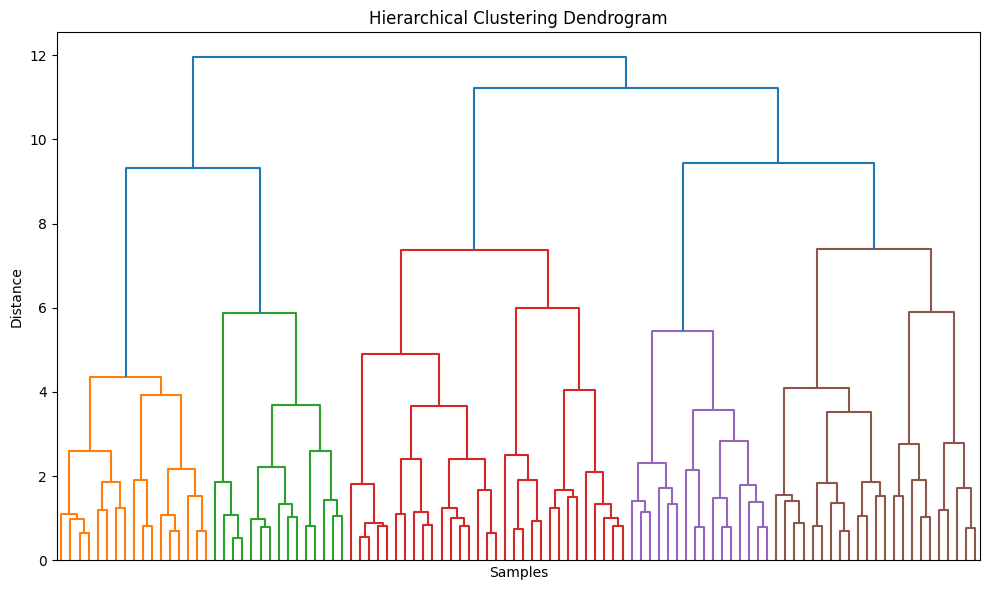

Dendrogram saved to: /home/wael/Patient Segmentation by Vital Signs/results/plots/dendrogram.png
Hierarchical flat clusters saved to: /home/wael/Patient Segmentation by Vital Signs/results/hierarchical_clusters.csv
Adjusted Rand Index (KMeans vs Agglomerative): 0.170
Adjusted Rand Index (KMeans vs Hierarchical): 0.170
KMeans silhouette: 0.176, Agglomerative silhouette: 0.154, Hierarchical silhouette: 0.154
Cluster stability summary saved to: /home/wael/Patient Segmentation by Vital Signs/results/cluster_stability.csv


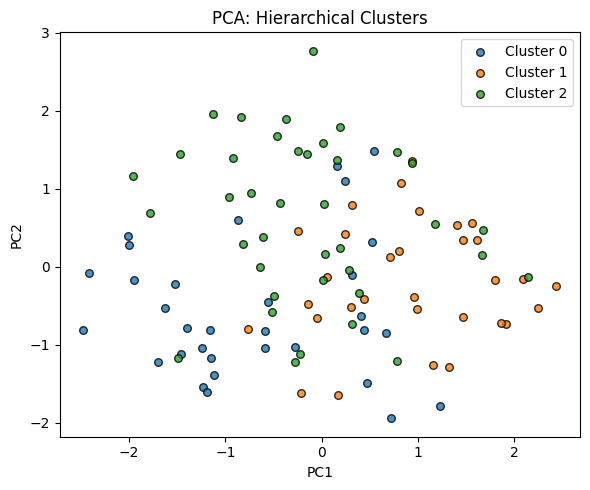

Saved PCA plot for hierarchical clusters to: /home/wael/Patient Segmentation by Vital Signs/results/plots/pca_hierarchical.png
Appended summary to segmentation report at: /home/wael/Patient Segmentation by Vital Signs/results/segmentation_report.txt


,method,n_clusters,silhouette,stability_ari_mean,stability_ari_std
0,kmeans_existing,3,0.176246,0.541154,0.178680
1,agglomerative,3,0.153692,0.352485,0.135052
2,hierarchical,3,0.153692,-0.003275,0.005246
3,kmeans_vs_agglomerative_ARI,3,NaN,0.169536,NaN
4,kmeans_vs_hierarchical_ARI,3,NaN,0.169536,NaN
5,agglomerative_vs_hierarchical_ARI,3,NaN,1.000000,NaN


In [29]:
# Section: Run hierarchical + comparison analysis

# Load scaled features and existing KMeans labels (if present)
X = load_scaled_features()
df_clusters, labels_k = read_existing_clusters()
if labels_k is None:
    print('No existing KMeans labels found; fitting KMeans with K=3 as fallback')
    labels_k = fit_kmeans(X, n_clusters=3)

n_clusters = int(np.unique(labels_k).shape[0])
print(f'Loaded {X.shape[0]} samples and {n_clusters} clusters (reference KMeans)')

# Linkage: try reading existing linkage, otherwise compute and save
Z = load_linkage()
if Z is None:
    print('No saved linkage found; computing linkage now...')
    Z, linkage_path = compute_and_save_linkage(X)
    print('Linkage matrix saved to:', linkage_path)
else:
    print('Loaded existing linkage matrix (saved file).')

# Dendrogram (uses loaded or computed Z)
dend_path = plot_dendrogram(Z=Z, out=os.path.join(PLOTS_DIR, 'dendrogram.png'))
print('Dendrogram saved to:', dend_path)

# Obtain hierarchical flat clusters by cutting linkage into n_clusters
labels_hier = flat_clusters_from_linkage(Z, n_clusters=n_clusters)
hier_path = save_hierarchical_clusters(labels_hier, df_ref=df_clusters)
print('Hierarchical flat clusters saved to:', hier_path)

# Agglomerative clustering (fit directly on X)
labels_agg = fit_agglomerative(X, n_clusters=n_clusters)

# Compare KMeans vs Agglomerative vs Hierarchical
ari_k_vs_agg = adjusted_rand_score(labels_k, labels_agg)
ari_k_vs_hier = adjusted_rand_score(labels_k, labels_hier)
ari_agg_vs_hier = adjusted_rand_score(labels_agg, labels_hier)

sil_k = silhouette_score(X, labels_k) if n_clusters >= 2 else float('nan')
sil_agg = silhouette_score(X, labels_agg) if n_clusters >= 2 else float('nan')
sil_hier = silhouette_score(X, labels_hier) if n_clusters >= 2 else float('nan')

print(f'Adjusted Rand Index (KMeans vs Agglomerative): {ari_k_vs_agg:.3f}')
print(f'Adjusted Rand Index (KMeans vs Hierarchical): {ari_k_vs_hier:.3f}')
print(f'KMeans silhouette: {sil_k:.3f}, Agglomerative silhouette: {sil_agg:.3f}, Hierarchical silhouette: {sil_hier:.3f}')

# Bootstrap stability
kmeans_fn = lambda X_sub: fit_kmeans(X_sub, n_clusters=n_clusters)
agg_fn = lambda X_sub: fit_agglomerative(X_sub, n_clusters=n_clusters)
hier_fn = lambda X_sub: flat_clusters_from_linkage(linkage(X_sub), n_clusters=n_clusters)

k_mean_ari_mean, k_mean_ari_std = bootstrap_stability(labels_k, X, kmeans_fn, n_runs=40)
agg_ari_mean, agg_ari_std = bootstrap_stability(labels_agg, X, agg_fn, n_runs=40)
hier_ari_mean, hier_ari_std = bootstrap_stability(labels_hier, X, hier_fn, n_runs=40)

summary = pd.DataFrame([
    {'method': 'kmeans_existing', 'n_clusters': n_clusters, 'silhouette': float(sil_k), 'stability_ari_mean': k_mean_ari_mean, 'stability_ari_std': k_mean_ari_std},
    {'method': 'agglomerative', 'n_clusters': n_clusters, 'silhouette': float(sil_agg), 'stability_ari_mean': agg_ari_mean, 'stability_ari_std': agg_ari_std},
    {'method': 'hierarchical', 'n_clusters': n_clusters, 'silhouette': float(sil_hier), 'stability_ari_mean': hier_ari_mean, 'stability_ari_std': hier_ari_std},
    {'method': 'kmeans_vs_agglomerative_ARI', 'n_clusters': n_clusters, 'silhouette': float('nan'), 'stability_ari_mean': float(ari_k_vs_agg), 'stability_ari_std': float('nan')},
    {'method': 'kmeans_vs_hierarchical_ARI', 'n_clusters': n_clusters, 'silhouette': float('nan'), 'stability_ari_mean': float(ari_k_vs_hier), 'stability_ari_std': float('nan')},
    {'method': 'agglomerative_vs_hierarchical_ARI', 'n_clusters': n_clusters, 'silhouette': float('nan'), 'stability_ari_mean': float(ari_agg_vs_hier), 'stability_ari_std': float('nan')},
])

out_csv = os.path.join(OUT_DIR, 'cluster_stability.csv')
summary.to_csv(out_csv, index=False)
print('Cluster stability summary saved to:', out_csv)

# Save hierarchical PCA plot
pca_hier_out = plot_pca_colored_by_labels(X, labels_hier, out=os.path.join(PLOTS_DIR, 'pca_hierarchical.png'), title='PCA: Hierarchical Clusters')
print('Saved PCA plot for hierarchical clusters to:', pca_hier_out)

# Append to segmentation report
rep_path = os.path.join(OUT_DIR, 'segmentation_report.txt')
lines = [
    '\n### Hierarchical & Stability Analysis\n',
    f'Number of clusters (reference KMeans): {n_clusters}\n',
    f'Adjusted Rand Index (KMeans vs Agglomerative): {ari_k_vs_agg:.3f}\n',
    f'Adjusted Rand Index (KMeans vs Hierarchical): {ari_k_vs_hier:.3f}\n',
    f'KMeans silhouette: {sil_k:.3f}, bootstrap ARI mean: {k_mean_ari_mean:.3f} ± {k_mean_ari_std:.3f}\n',
    f'Agglomerative silhouette: {sil_agg:.3f}, bootstrap ARI mean: {agg_ari_mean:.3f} ± {agg_ari_std:.3f}\n',
    f'Hierarchical silhouette: {sil_hier:.3f}, bootstrap ARI mean: {hier_ari_mean:.3f} ± {hier_ari_std:.3f}\n',
]
with open(rep_path, 'a') as fh:
    fh.writelines(lines)
print('Appended summary to segmentation report at:', rep_path)

# Display summary inline
summary

In [14]:
# Section: Notebook best practices & magics (short demo)
# Matplotlib inline, timing magics, and shell commands
%matplotlib inline
%timeit -n 3 np.sum(np.random.random((1000, 1000)))
!ls -la results | head -n 10


8.46 ms ± 652 μs per loop (mean ± std. dev. of 7 runs, 3 loops each)
ls: cannot access 'results': No such file or directory


In [25]:
# Section: Interactive widgets (simple demo)
try:
    import ipywidgets as widgets
    from IPython.display import display

    slider = widgets.IntSlider(value=5, min=1, max=20, description='n_clusters')
    display(slider)

    def on_change(change):
        if change['name'] == 'value':
            print('New slider value:', change['new'])

    slider.observe(on_change)
except Exception as e:
    print('ipywidgets not available; install with `pip install ipywidgets`')


IntSlider(value=5, description='n_clusters', max=20, min=1)

In [23]:
# Section: Exporting notebook & git note
# Convert to script (optional)
!jupyter nbconvert --to script notebooks/03_cluster_analysis.ipynb --output scripts/cluster_analysis_from_notebook

# Show minimal git flow hint
print('Run: !git add results/plots/dendrogram.png results/cluster_stability.csv results/segmentation_report.txt && git commit -m "Add hierarchical clustering outputs"')

[NbConvertApp] WARNING | pattern 'notebooks/03_cluster_analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=T

In [ ]:
# Section: Display saved plots inline (robust view)
import os
from PIL import Image
import matplotlib.pyplot as plt

plot_files = [
    os.path.join('results','plots','dendrogram.png'),
    os.path.join('results','plots','pca_original_vs_cluster.png'),
    os.path.join('results','plots','pca_with_centroids.png'),
    os.path.join('results','plots','pca_hierarchical.png'),
    os.path.join('results','plots','silhouette_plot.png'),
    os.path.join('results','plots','silhouette_plot_hierarchical.png'),
    os.path.join('results','plots','pairplot_by_cluster.png'),
    os.path.join('results','plots','pairplot_by_hierarchical.png'),
    os.path.join('results','plots','cluster_centers_heatmap.png'),
]

found_any = False
for p in plot_files:
    print('\n---', os.path.basename(p), '---')
    if os.path.exists(p):
        found_any = True
        try:
            img = Image.open(p)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(p))
            plt.show()
        except Exception as e:
            print(f'Could not display {p}: {e}')
    else:
        print(f'Missing: {p}')

if not found_any:
    print('No plot images were found in results/plots/. Ensure the analysis cells have been run and created the plots.')